# DeepSHAP and IntegratedGradients for cell type classification interpretabilty

[scANVIExplainer based on DeepSHAP](https://www.nature.com/articles/s41592-024-02511-3)

[CAPTUM IntegratedGradients](https://captum.ai/api/integrated_gradients.html)

In [1]:
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

In [21]:
import shap
from scanvi_explainer import SCANVIDeep
from scanvi_explainer.plots import feature_plot

## Load data and tain scanvi

https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.pbmc_dataset.html#scvi.data.pbmc_dataset

In [3]:
# adata = scvi.data.purified_pbmc_dataset()
adata = scvi.data.pbmc_dataset()
adata.layers["counts"] = adata.X.copy()
adata.obs["batch"] = adata.obs["batch"].astype("category")

adata

INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'
    layers: 'counts'

In [4]:
adata.var_names = adata.var["gene_symbols"]

In [5]:
adata.obs.str_labels.value_counts()

str_labels
CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: count, dtype: int64

In [6]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

print("# cells, # genes after filtering:", adata.shape)

# cells, # genes before filtering: (11990, 3346)
# cells, # genes after filtering: (11990, 3346)


In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
)

In [8]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    labels_key="str_labels",
    unlabeled_category="unknown",
)

In [9]:
# model = scvi.model.SCANVI(adata)
model = scvi.model.SCANVI.load("pbmc_model", adata=adata)
model

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File pbmc_model/model.pt already downloaded                                                               


/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path

ScanVI Model with the following params: 
unlabeled_category: unknown, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Trained
Model's adata is minified?: False

In [10]:
# model.train(
#     max_epochs=400,
#     plan_kwargs={"lr": 1e-3},
#     early_stopping=True,
#     check_val_every_n_epoch=1,
#     train_size=0.8,
#     validation_size=0.2,
# )
# model.save("pbmc_model")

## Inspect scanvi training and test performance

In [15]:
adata.obsm["X_scANVI"] = model.get_latent_representation()

In [14]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scANVI", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.3)

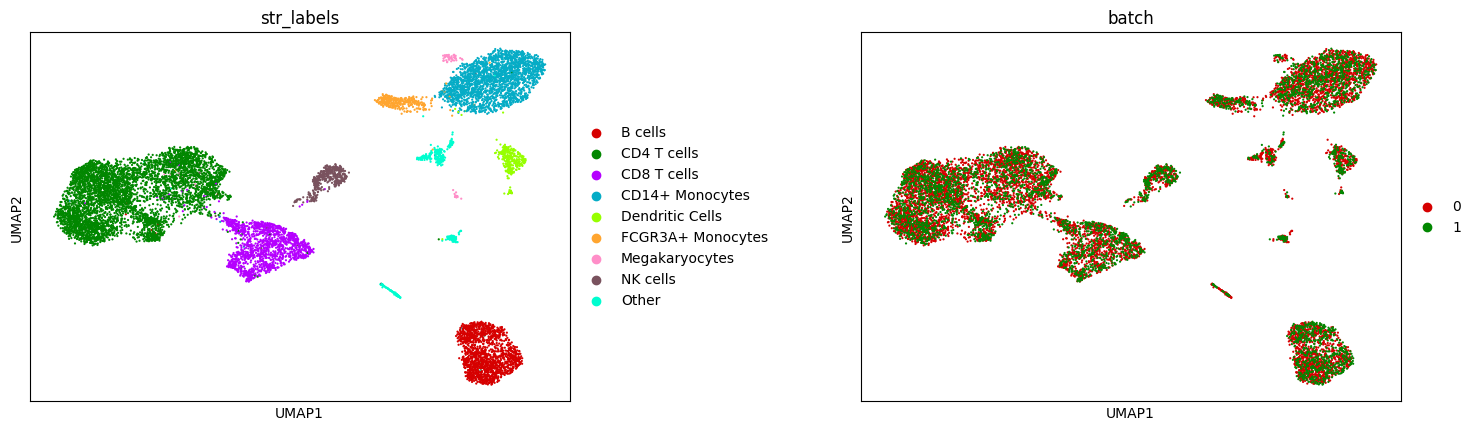

In [15]:
sc.pl.umap(adata, color=["str_labels", "batch"], ncols=2, wspace=0.4, palette=cc.glasbey_light)

In [16]:
model.history.keys()

dict_keys(['train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'validation_classification_loss', 'validation_accuracy', 'validation_f1_score', 'validation_calibration_error', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

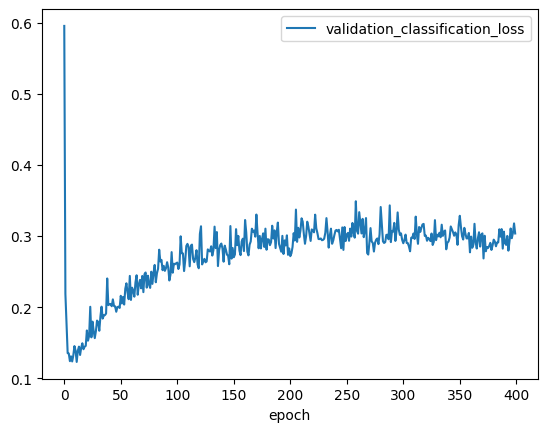

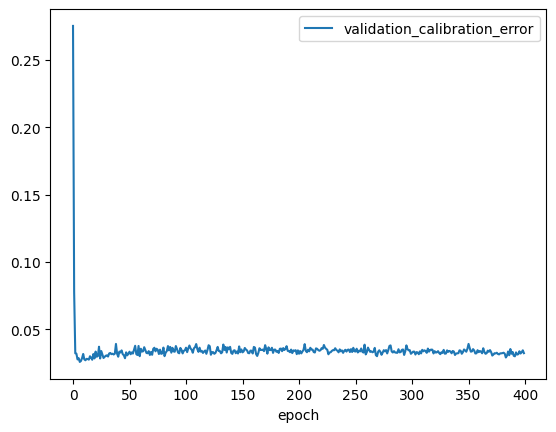

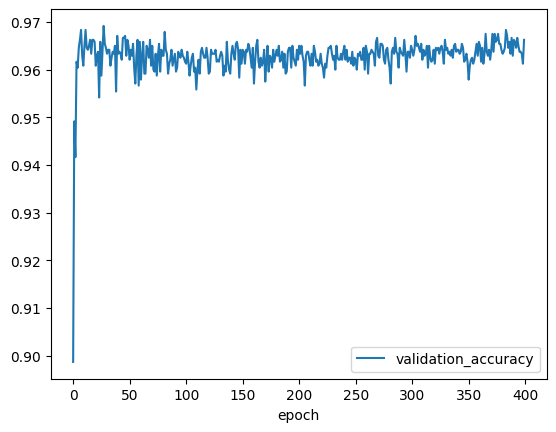

In [17]:
metrics = ["classification_loss", "calibration_error", "accuracy"]

for metric in metrics:
    model.history[f"validation_{metric}"].plot()

In [18]:
model.predict(adata)

array(['CD4 T cells', 'CD4 T cells', 'CD14+ Monocytes', ..., 'NK cells',
       'B cells', 'CD14+ Monocytes'], dtype='<U17')

## SHAP

https://shap.readthedocs.io/en/latest/generated/shap.DeepExplainer.html#shap.DeepExplainer

https://github.com/brickmanlab/scanvi-explainer/blob/master/src/scanvi_explainer/scanvi_deep.py


In [31]:
e = SCANVIDeep(model, train_size=0.8, batch_size=128)
e

SCANVIDeep with the following parameters:
train_size=0.8, test_size=0.2, batch_size=128, labels_key=str_labels, layers_key=counts
training_on=cuda:0

In [32]:
shap_values = e.shap_values()

  0%|          | 0/9 [00:00<?, ?it/s]

In [44]:
len(shap_values)

9

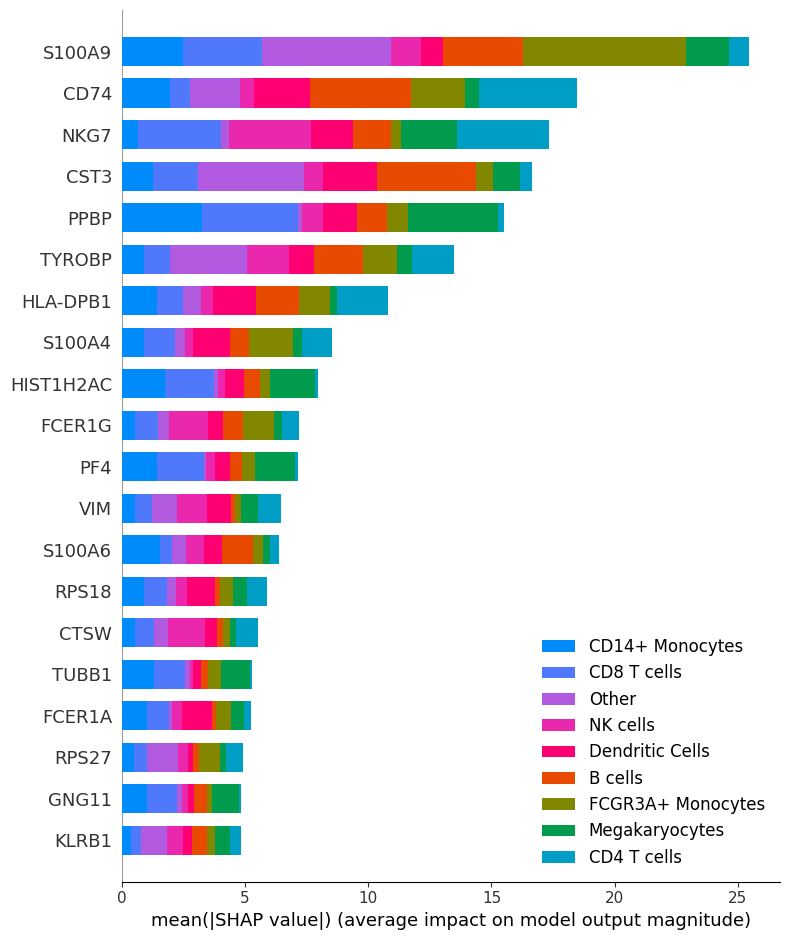

In [37]:
shap.summary_plot(
    shap_values,
    e.test["X"],
    feature_names=model.adata.var_names,
    class_names=model.adata.obs.str_labels.cat.categories,
)

ValueError: Could not interpret value `feature` for `y`. An entry with this name does not appear in `data`.

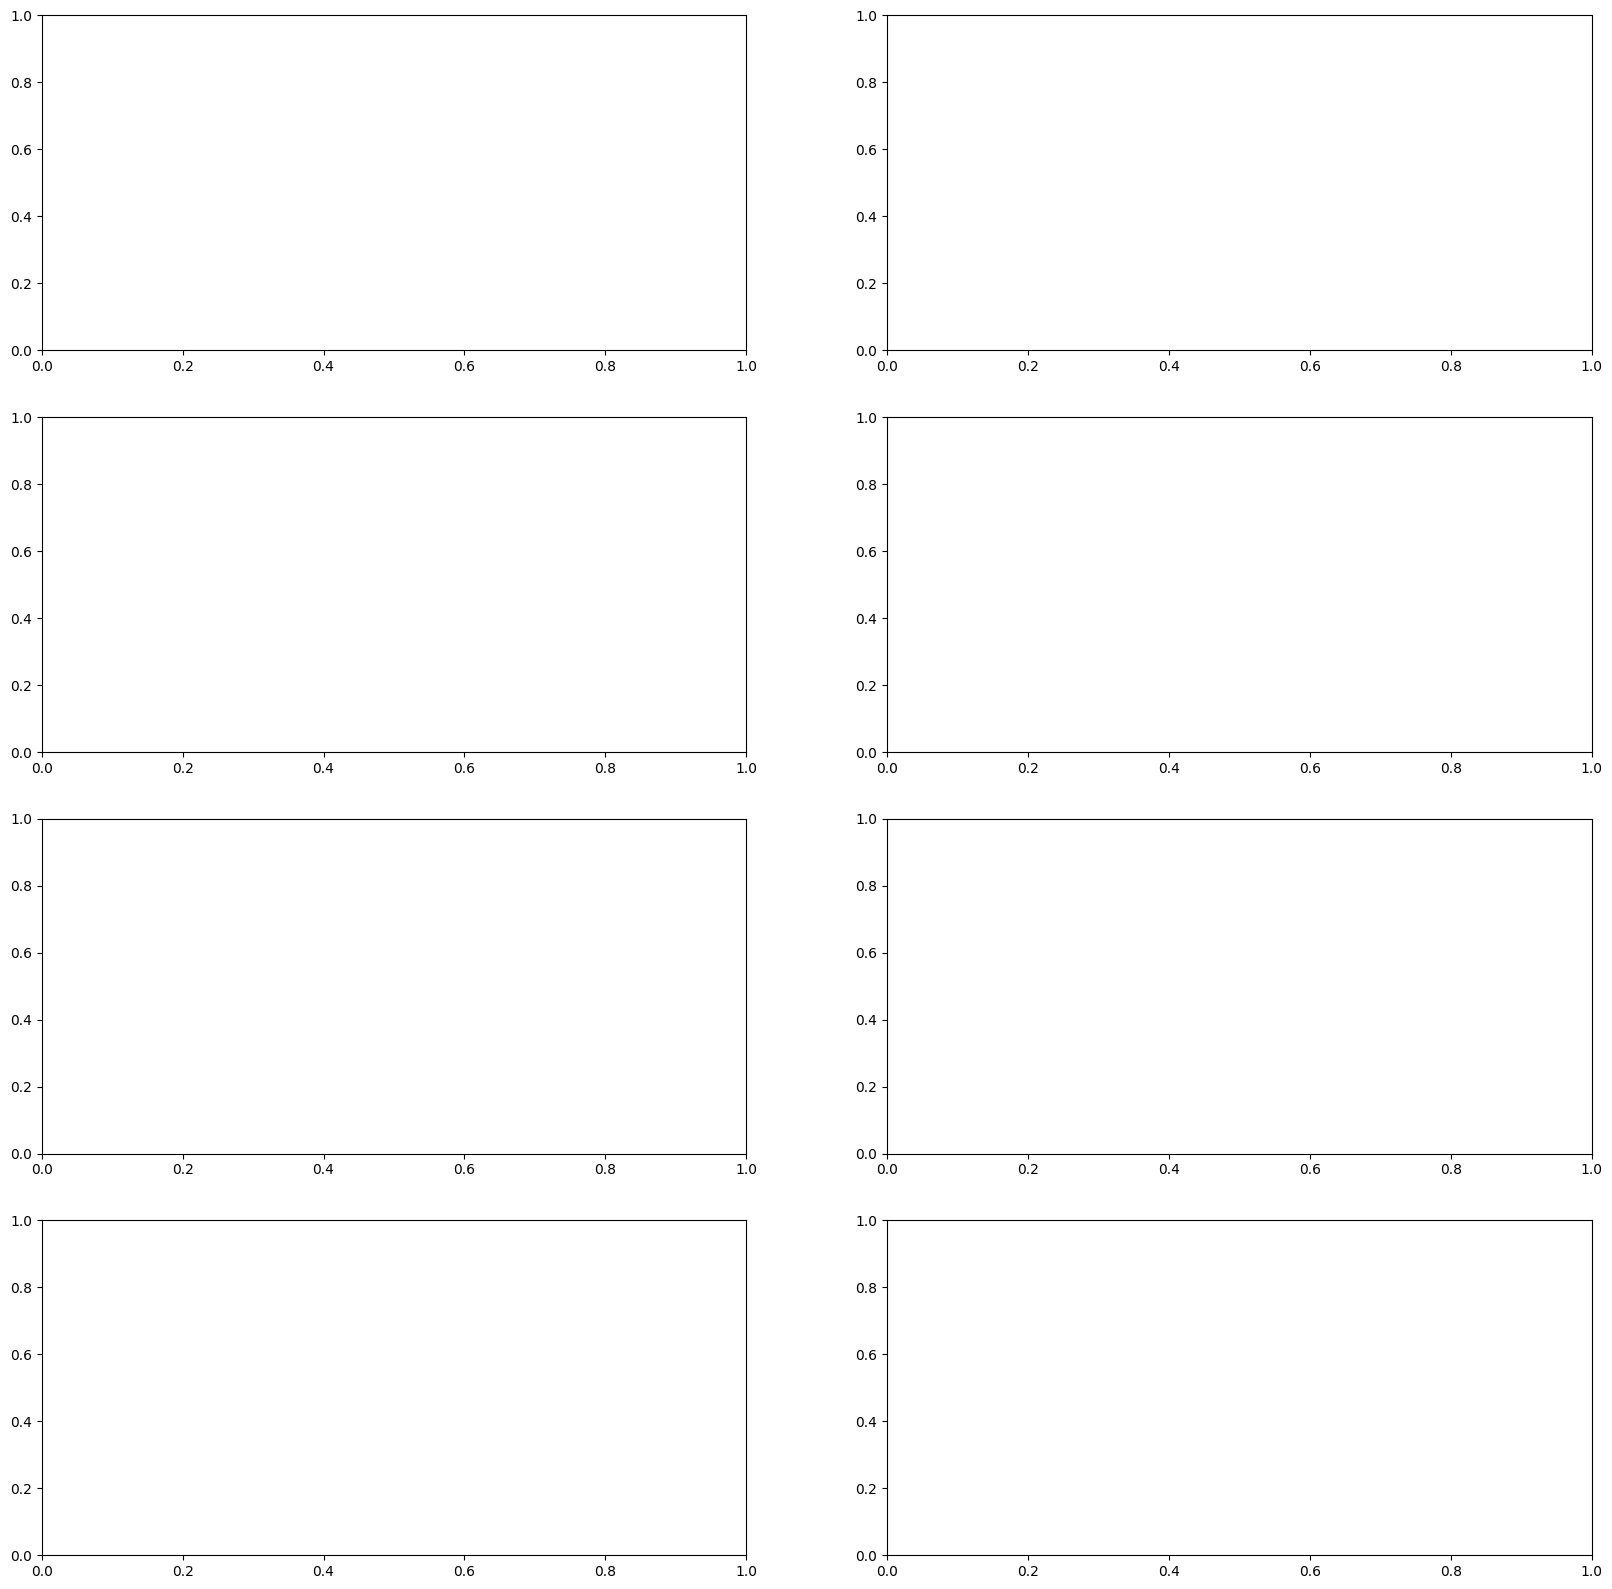

In [41]:
feature_plot(e, shap_values, subset=True, top_n=10)

## Integrated Gradients

In [13]:
def scanvi_integrated_gradients(model, adata):
    import torch
    from captum.attr import IntegratedGradients
    from scvi import REGISTRY_KEYS

    adata = model._validate_anndata(adata)
    scdl = model._make_data_loader(
        adata=adata,
        indices=np.arange(adata.n_obs),
        batch_size=512,
    )

    ig = IntegratedGradients(model.module.classify)
    attributions = []
    for _, tensors in enumerate(scdl):
        x = tensors[REGISTRY_KEYS.X_KEY]
        batch = tensors[REGISTRY_KEYS.BATCH_KEY]

        cont_key = REGISTRY_KEYS.CONT_COVS_KEY
        cont_covs = tensors[cont_key] if cont_key in tensors.keys() else None

        cat_key = REGISTRY_KEYS.CAT_COVS_KEY
        cat_covs = tensors[cat_key] if cat_key in tensors.keys() else None

        pred = model.module.classify(
            x,
            batch_index=batch,
            cat_covs=cat_covs,
            cont_covs=cont_covs,
        )
        pred = pred.argmax(dim=1)

        attribution = ig.attribute((x), target=pred)
        attributions.append(attribution)

    attributions = torch.cat(attributions, dim=0).detach().numpy()

    return attributions

In [14]:
attributions = scanvi_integrated_gradients(model, adata)
attributions

array([[ 0.37997491, -0.        , -0.        , ..., -0.43021695,
         0.        ,  0.        ],
       [ 0.        , -0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.04889866,
         0.        , -0.        ],
       ...,
       [ 0.16175631,  0.32911087,  0.        , ...,  0.70095059,
        -0.        ,  0.        ],
       [-0.18589739, -0.        , -0.        , ..., -0.27366963,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.14548151,
         0.        ,  0.        ]])

In [15]:
attributions.shape

(11990, 1200)

In [19]:
# adapted from https://github.com/Genentech/scimilarity/blob/main/src/scimilarity/interpreter.py


def get_ranked_genes(adata, attrs: "np.ndarray") -> "pd.DataFrame":
    """Get the ranked gene list based on highest attributions.

    Parameters
    ----------
    attr: numpy.ndarray
        Attributions matrix.

    Returns
    -------
    pandas.DataFrame
        A pandas dataframe containing the ranked attributions for each gene

    Examples
    --------
    >>> attrs_df = interpreter.get_ranked_genes(attrs)
    """
    import numpy as np
    import pandas as pd

    mean_attrs = attrs.mean(axis=0)
    idx = mean_attrs.argsort()[::-1]
    df = {
        "gene": np.array(adata.var_names)[idx],
        "gene_idx": idx,
        "attribution_mean": mean_attrs[idx],
        "attribution_std": attrs.std(axis=0)[idx],
        "cells": attrs.shape[0],
    }
    return pd.DataFrame(df)

In [20]:
df = get_ranked_genes(adata, attributions)
df

,gene,gene_idx,attribution_mean,attribution_std,cells
0,RPS27,79,6.546110,4.916856,11990
1,RPS18,417,4.565697,3.372931,11990
2,RPLP1,880,2.265857,1.978872,11990
3,TMSB10,165,1.799142,4.362565,11990
4,RPS24,730,1.238037,1.296471,11990
...,...,...,...,...,...
1195,IER2,1089,-0.130773,0.373750,11990
1196,ARPC3,799,-0.164078,0.352463,11990
1197,CYBA,938,-0.232724,0.502685,11990
1198,JUNB,1085,-0.265168,1.042599,11990


In [24]:
# adapted from https://github.com/Genentech/scimilarity/blob/main/src/scimilarity/interpreter.py


def plot_ranked_genes(
    attrs_df: "pd.DataFrame",
    n_plot: int = 15,
    filename: str | None = None,
):
    """Plot the ranked gene attributions.

    Parameters
    ----------
    attrs_df: pandas.DataFrame
        Dataframe of ranked attributions.
    n_plot: int
        The number of top genes to plot.
    filename: str, optional
        The filename to save to plot as.

    Examples
    --------
    >>> interpreter.plot_ranked_genes(attrs_df)
    """
    import matplotlib as mpl
    import numpy as np
    import seaborn as sns

    mpl.rcParams["pdf.fonttype"] = 42

    df = attrs_df.head(n_plot)
    ci = 1.96 * df["attribution_std"] / np.sqrt(df["cells"])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2), dpi=200)
    sns.barplot(ax=ax, data=df, x="gene", y="attribution_mean", hue="gene", dodge=False)
    ax.set_yticks([])
    plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)

    ax.errorbar(
        df["gene"].values,
        df["attribution_mean"].values,
        yerr=ci,
        ecolor="black",
        fmt="none",
    )
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    if filename:  # save the figure
        fig.savefig(filename, bbox_inches="tight")

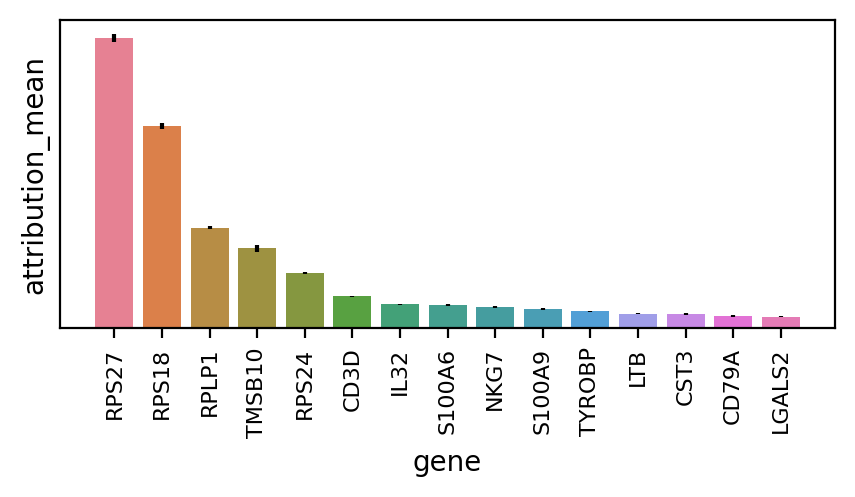

In [25]:
plot_ranked_genes(df, n_plot=15)